# Time series forecasting using N-Beats.

In [ ]:
# GPU 런타임 설정 부탁드립니다.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
#env setup
!rm -rf /content/n-beats
%cd /content
!git clone https://github.com/philipperemy/n-beats.git
!pip install tensorflow
%cd /content/n-beats
!mv nbeats_keras examples/
!mv nbeats_pytorch examples/
%cd ./examples
!mkdir /content/drive/MyDrive/n_beats_output

/content
Cloning into 'n-beats'...
remote: Enumerating objects: 1738, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 1738 (delta 191), reused 304 (delta 178), pack-reused 1397
Receiving objects: 100% (1738/1738), 214.23 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (551/551), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/n-beats
/content/n-beats/examples


In [24]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else :
  print('Found GPU')

Found GPU at: /device:GPU:0


In [25]:
%matplotlib inline
import warnings,itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [27]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch
        
def n_beats_merge(fruit_index, file_path, horizen, window_size, train_ratio, epoch_num):
  forecast_length = horizen
  backcast_length = window_size
  batch_size = 32 

  milk = pd.read_csv(file_path).iloc[:,fruit_index]
  milk = milk.values.flatten()

  # data backcast/forecast generation.
  x, y = [], []
  for epoch in range(backcast_length, len(milk) - forecast_length):
      x.append(milk[epoch - backcast_length:epoch])
      y.append(milk[epoch:epoch + forecast_length])
  x = np.array(x)
  y = np.array(y)

  # split train/test.
  c = int(len(x) * train_ratio)
  x_train, y_train = x[:c], y[:c]
  x_test, y_test = x[c:], y[c:]

  # normalization.
  norm_constant = np.max(x_train)
  x_train, y_train = x_train / norm_constant, y_train / norm_constant
  x_test, y_test = x_test / norm_constant, y_test / norm_constant

  # model
  net = NBeatsNet(
      stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
      forecast_length=forecast_length,
      backcast_length=backcast_length,
      hidden_layer_units=128,
  )
  optimiser = optim.Adam(lr=1e-4, params=net.parameters())

  grad_step = 0
  forecast= []
  for epoch in range(epoch_num): #1000
      if epoch+1 % 100 == 0 : print(epoch,end='|')

      # train.
      net.train()
      train_loss = []
      for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
          grad_step += 1
          optimiser.zero_grad()
          _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
          loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
          train_loss.append(loss.item())
          loss.backward()
          optimiser.step()
      train_loss = np.mean(train_loss)

      # test.
      net.eval()
      _, forecast = net(torch.tensor(x_test, dtype=torch.float))
      test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
      p = forecast.detach().numpy()
      if epoch+1 % 100 == 0:
          subplots = [221, 222, 223, 224]
          plt.figure(1)
          for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
              ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
              plt.subplot(subplots[plot_id])
              plt.grid()
              plot_scatter(range(0, backcast_length), xx, color='b')
              plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
              plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
          plt.show()

          with torch.no_grad():
              save(net, optimiser, grad_step)
          print(f'epoch = {str(epoch).zfill(4)}, '
                f'grad_step = {str(grad_step).zfill(6)}, '
                f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                f'te_loss (epoch) = {1000 * test_loss:.3f}')
      
  return p, y_test, norm_constant

In [28]:
# Test case
csv_cases = ['pre_price', 'pre_price_s_7d','pre_price_s_14d', 'pre_price_s_21d', 'pre_price_s_28d']
window_cases = [44, 24, 44, 28, 135, 81, 145, 89, 89, 52, 94, 59, 88, 47, 88, 57, 79, 39, 74, 45]  #42
# horizon_cases = [a+1 for a in range(7)] + [14]
horizon_cases = [1,2,3]

all_cases = list(itertools.product(*[csv_cases,window_cases,horizon_cases]))
print("경우의 수 : %s개 | ex:" %len(all_cases), all_cases[0])

경우의 수 : 300개 | ex: ('pre_price', 44, 1)


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166330720
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166326352
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166324384
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166335376
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166320064
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=44, forecast_length=1, share_thetas=False) at @140145166325152
0|

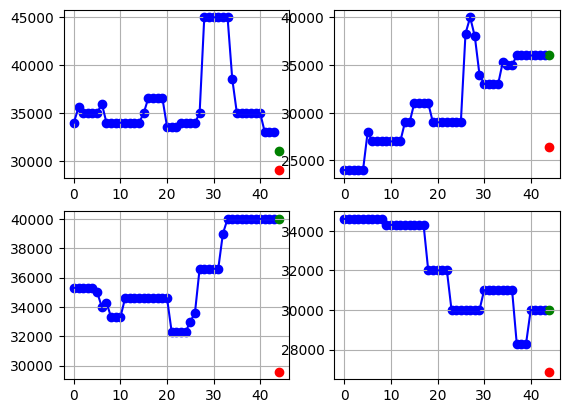

epoch = 0000, grad_step = 000228, tr_loss (epoch) = 68.267, te_loss (epoch) = 3.938


In [47]:
# 실제데이터 및 예측결과를 정리해서 구글 드라이브 아래 경로에 저장됩니다.
# /content/drive/MyDrive/n_beats_output/

########################################
# 잘 돌아가시면 break 지우고 모두 실행해주세요  #
########################################

for i in all_cases:
  print('#'*50)
  print(i)
  y_hat, y_real, norm_constant = n_beats_merge(
      fruit_index = 0, # 예측할 항목의 index
      file_path = '/content/drive/MyDrive/workspace/data/'+str(i[0])+'.csv',
      horizen = i[2],
      window_size = i[1],
      train_ratio = 0.9,
      epoch_num = 100)
  df = pd.DataFrame(np.array([y_hat*norm_constant, y_real*norm_constant]).T[0],columns=['y_hat','y_real'])
  df.to_csv(f'/content/drive/MyDrive/n_beats_output/f_{i[0]}_w_{i[1]}_h_{i[2]}.csv')
  break